In [1]:
# 1.04.2024
# обновлена схема, построены графики для пилотного сигнала

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

На картинке изображена структурная схема модели, которую планируется реализовать.

- Желтым цветом отмечены блоки, функции для которых на данный момент прописаны.

- Синим цветом отмечены блоки, над которыми либо ведется работа, либо они просто пропущены (тк не написан другой блок, без которого этот не может обойтись), но будут в финальной модели.

- Красным цветом отмечены блоки, которые делать не планируется.

![Структурная схема модели](model_structure.png)

Каждый блок этой диаграммы (или набор блоков) реализован как отдельная функция, преобразующая входной в нее массив.

Основной управляющий файл `ofdm_modem.m` сохраняет данные с выхода каждого блока в txt файл. Поэтому можно смотреть как преобразуется сигнал от блока к блоку.

На вход он принимает следующие параметры - порядок модулятора `M` (2,4,8,16,64...); длину фрейма `fr_len` (степень двойки); соотношение сигнал/шум на приемнике в децибелах `SNR_dB`; длину циклического префикса `cp_length`.

In [2]:
M = 16; # e.g. 2, 4, 8 -> PSK; 16, 64... -> QAM
fr_len = 64; # the length of OFDM frame
SNR_dB = 20; # [dBW] the signal power is normalized to 1 W
cp_length = fr_len/2; # the size of cyclic prefix

### Созвездие модулятора и отсчеты принятого сигнала в частотной области

In [3]:
info_frame = pd.read_csv('model_290324_CP_ber_evm\\info_frame.txt', sep=',', index_col=False, header=None, names=['Re', 'Im'])
info_frame_fd = pd.read_csv('model_290324_CP_ber_evm\\info_frame_fd.txt', sep=',', index_col=False, header=None, names=['Re', 'Im'])
metrics = pd.read_csv('model_290324_CP_ber_evm\\metrics.txt', sep=',', index_col=False, header=None, names=['value'])

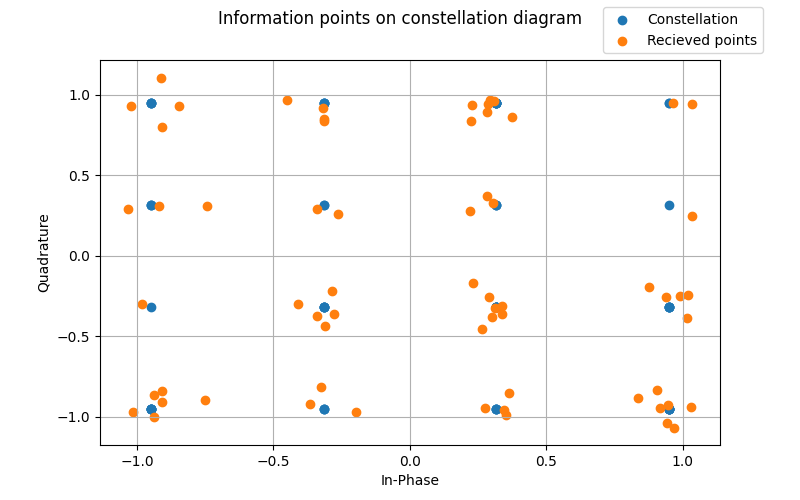

In [4]:
fig1 = plt.figure(figsize=(8,5))
ax_1 = fig1.add_subplot(111)
ax_1.scatter(info_frame['Re'], info_frame['Im'], label='Constellation')
ax_1.scatter(info_frame_fd['Re'], info_frame_fd['Im'], label='Recieved points')
ax_1.set_ylabel("Quadrature")
ax_1.set_xlabel(r"In-Phase")
ax_1.legend(bbox_to_anchor=(0.8, 1))
ax_1.grid()
#ax_1.set_title('Real part')
fig1.suptitle('Information points on constellation diagram')
plt.show()

### Фрейм во временной области и добавление циклического префикса

In [5]:
info_frame_td = pd.read_csv('model_290324_CP_ber_evm\\info_frame_td.txt', sep=',', index_col=False, header=None, names=['Re', 'Im'])

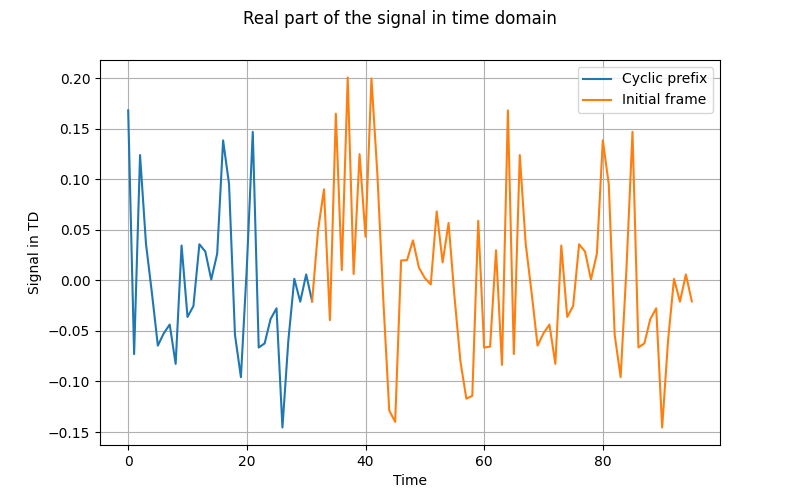

In [6]:
cp_size = int(len(info_frame_td['Re'])/3)

fig2 = plt.figure(figsize=(8,5))
ax_1 = fig2.add_subplot(111)
ax_1.plot(info_frame_td.index[:cp_size], info_frame_td['Re'][:cp_size], label='Cyclic prefix')
ax_1.plot(info_frame_td.index[cp_size-1:], info_frame_td['Re'][cp_size-1:], label='Initial frame')
ax_1.set_ylabel("Signal in TD")
ax_1.set_xlabel(r"Time")
ax_1.legend()
ax_1.grid()
#ax_1.set_title('Real part')
fig2.suptitle('Real part of the signal in time domain')
plt.show()

### Пилотный сигнал и его спектр

In [7]:
pilots_frame = pd.read_csv('model_290324_CP_ber_evm\\pilots_frame.txt', sep=',', index_col=False, header=None, names=['Re', 'Im'])
pilots_frame_td = pd.read_csv('model_290324_CP_ber_evm\\pilots_frame_td.txt', sep=',', index_col=False, header=None, names=['Re', 'Im'])

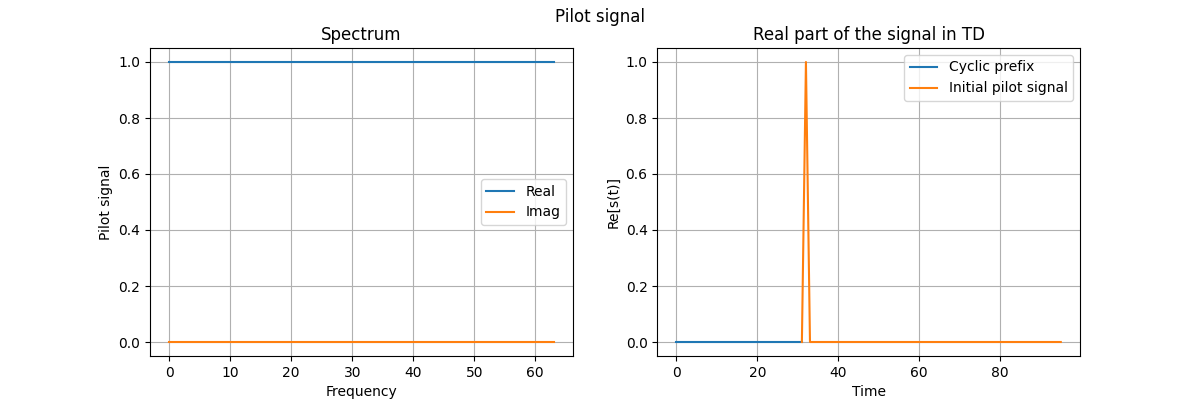

In [8]:
fig3 = plt.figure(figsize=(12,4))
ax_1 = fig3.add_subplot(121)
ax_1.plot(pilots_frame.index, pilots_frame['Re'], label='Real')
ax_1.plot(pilots_frame.index, pilots_frame['Im'], label='Imag')
ax_1.set_ylabel("Pilot signal")
ax_1.set_xlabel(r"Frequency")
ax_1.legend()
ax_1.grid()
ax_1.set_title('Spectrum')
fig3.suptitle('Pilot signal')

ax_2 = fig3.add_subplot(122)
ax_2.plot(pilots_frame_td.index[:cp_size], pilots_frame_td['Re'][:cp_size], label='Cyclic prefix')
ax_2.plot(pilots_frame_td.index[cp_size-1:], pilots_frame_td['Re'][cp_size-1:], label='Initial pilot signal')
ax_2.set_ylabel("Re[s(t)]")
ax_2.set_xlabel(r"Time")
ax_2.legend()
ax_2.grid()
ax_2.set_title('Real part of the signal in TD')
plt.show()

### Зависимость EVM и Uncoded BER от SNR